In [424]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv
/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv
/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv


In [425]:
import seaborn as sns
import nltk
import spacy
import re
import spacy
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk import tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from IPython.display import Image
from spacy import displacy
from transformers import pipeline
%matplotlib inline
from nltk import word_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [426]:
summaries_train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv")
summaries_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv")
prompts_train = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv")
prompts_test = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv")
sample_submission = pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv")

In [427]:
summaries_train.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0020ae56ffbf    ebad26  They would rub it up with soda to make the sme...   
2  004e978e639e    3b9047  In Egypt, there were many occupations and soci...   
3  005ab0199905    3b9047  The highest class was Pharaohs these people we...   
4  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   

    content   wording  
0  0.205683  0.380538  
1 -0.548304  0.506755  
2  3.128928  4.231226  
3 -0.210614 -0.471415  
4  3.272894  3.219757

In [428]:
summaries_test.head()

student_id prompt_id            text
0  000000ffffff    abc123  Example text 1
1  111111eeeeee    def789  Example text 2
2  222222cccccc    abc123  Example text 3
3  333333dddddd    def789  Example text 4

In [429]:
prompts_train.head()

prompt_id                                    prompt_question  \
0    39c16e  Summarize at least 3 elements of an ideal trag...   
1    3b9047  In complete sentences, summarize the structure...   
2    814d6b  Summarize how the Third Wave developed over su...   
3    ebad26  Summarize the various ways the factory would u...   

                prompt_title  \
0                 On Tragedy   
1  Egyptian Social Structure   
2             The Third Wave   
3    Excerpt from The Jungle   

                                         prompt_text  
0  Chapter 13 \r\nAs the sequel to what has alrea...  
1  Egyptian society was structured like a pyramid...  
2  Background \r\nThe Third Wave experiment took ...  
3  With one member trimming beef in a cannery, an...

In [430]:
prompts_test.head()

prompt_id prompt_question     prompt_title       prompt_text
0    abc123    Summarize...  Example Title 1  Heading\nText...
1    def789    Summarize...  Example Title 2  Heading\nText...

In [431]:
sample_submission.head()

student_id  content  wording
0  000000ffffff      0.0      0.0
1  111111eeeeee      0.0      0.0
2  222222cccccc      0.0      0.0
3  333333dddddd      0.0      0.0

In [432]:
summaries_train.dtypes

student_id     object
prompt_id      object
text           object
content       float64
wording       float64
dtype: object

In [433]:
summaries_test.dtypes

student_id    object
prompt_id     object
text          object
dtype: object

In [434]:
prompts_train.dtypes

prompt_id          object
prompt_question    object
prompt_title       object
prompt_text        object
dtype: object

In [435]:
prompts_test.dtypes

prompt_id          object
prompt_question    object
prompt_title       object
prompt_text        object
dtype: object

In [436]:
sample_submission.dtypes

student_id     object
content       float64
wording       float64
dtype: object

In [437]:
profile = ProfileReport(summaries_train, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

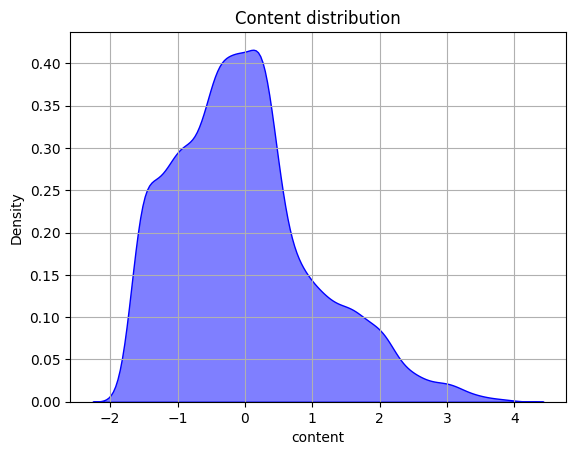

In [438]:
sns.kdeplot(data = summaries_train, x = "content",color = "b", alpha = .5, fill = True)
plt.title("Content distribution")
plt.grid()

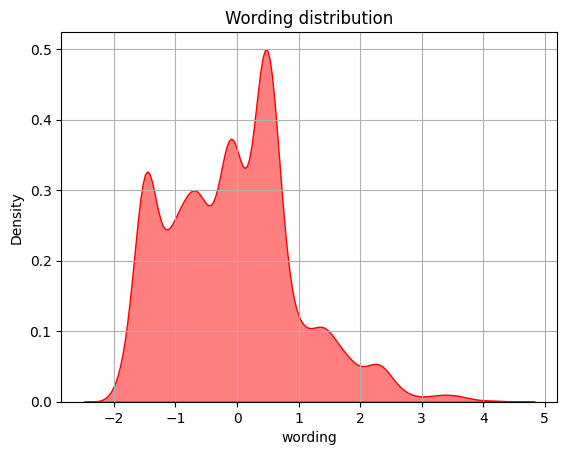

In [439]:
sns.kdeplot(data = summaries_train, x = "wording",color = "r", alpha = .5, fill = True)
plt.title("Wording distribution")
plt.grid()

In [440]:
summaries_train = summaries_train.merge(prompts_train , on = "prompt_id")
summaries_train.head()

student_id prompt_id                                               text  \
0  000e8c3c7ddb    814d6b  The third wave was an experimentto see how peo...   
1  0070c9e7af47    814d6b  The Third Wave developed  rapidly because the ...   
2  0095993991fe    814d6b  The third wave only started as an experiment w...   
3  00c20c6ddd23    814d6b  The experimen was orginally about how even whe...   
4  00d40ad10dc9    814d6b  The third wave developed so quickly due to the...   

    content   wording                                    prompt_question  \
0  0.205683  0.380538  Summarize how the Third Wave developed over su...   
1  3.272894  3.219757  Summarize how the Third Wave developed over su...   
2  0.205683  0.380538  Summarize how the Third Wave developed over su...   
3  0.567975  0.969062  Summarize how the Third Wave developed over su...   
4 -0.910596 -0.081769  Summarize how the Third Wave developed over su...   

     prompt_title                                        prompt_text  
0  The Third Wave  Background \r\nThe Third Wave experiment took ...  
1  The Third Wave  Background \r\nThe Third Wave experiment took ...  
2  The Third Wave  Background \r\nThe Third Wave experiment took ...  
3  The Third Wave  Background \r\nThe Third Wave experiment took ...  
4  The Third Wave  Background \r\nThe Third Wave experiment took ...

In [441]:
summaries_train["count_tp"] = summaries_train["text"].str.split().str.len() / summaries_train["prompt_text"].str.split().str.len()
summaries_train

student_id prompt_id  \
0     000e8c3c7ddb    814d6b   
1     0070c9e7af47    814d6b   
2     0095993991fe    814d6b   
3     00c20c6ddd23    814d6b   
4     00d40ad10dc9    814d6b   
...            ...       ...   
7160  fef3e85236e5    39c16e   
7161  ff0f65eecf02    39c16e   
7162  ff186473ea0a    39c16e   
7163  ff5e9e6068da    39c16e   
7164  ffe4a98093b2    39c16e   

                                                   text   content   wording  \
0     The third wave was an experimentto see how peo...  0.205683  0.380538   
1     The Third Wave developed  rapidly because the ...  3.272894  3.219757   
2     The third wave only started as an experiment w...  0.205683  0.380538   
3     The experimen was orginally about how even whe...  0.567975  0.969062   
4     The third wave developed so quickly due to the... -0.910596 -0.081769   
...                                                 ...       ...       ...   
7160  It has to be made on a complex storyline, with... -0.981265 -1.548900   
7161  Aristotle descirbes an ideal tradgedy as being... -0.511077 -1.589115   
7162  A tragedy should have a complex plan not a sim... -0.834946 -0.593749   
7163  Aristotle believed that the ideal tradegy shou... -0.157460 -0.165811   
7164  An ideal tragety has three elements that make ... -0.393310  0.627128   

                                        prompt_question    prompt_title  \
0     Summarize how the Third Wave developed over su...  The Third Wave   
1     Summarize how the Third Wave developed over su...  The Third Wave   
2     Summarize how the Third Wave developed over su...  The Third Wave   
3     Summarize how the Third Wave developed over su...  The Third Wave   
4     Summarize how the Third Wave developed over su...  The Third Wave   
...                                                 ...             ...   
7160  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7161  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7162  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7163  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7164  Summarize at least 3 elements of an ideal trag...      On Tragedy   

                                            prompt_text  count_tp  
0     Background \r\nThe Third Wave experiment took ...  0.102349  
1     Background \r\nThe Third Wave experiment took ...  0.340604  
2     Background \r\nThe Third Wave experiment took ...  0.100671  
3     Background \r\nThe Third Wave experiment took ...  0.127517  
4     Background \r\nThe Third Wave experiment took ...  0.045302  
...                                                 ...       ...  
7160  Chapter 13 \r\nAs the sequel to what has alrea...  0.054636  
7161  Chapter 13 \r\nAs the sequel to what has alrea...  0.049669  
7162  Chapter 13 \r\nAs the sequel to what has alrea...  0.048013  
7163  Chapter 13 \r\nAs the sequel to what has alrea...  0.081126  
7164  Chapter 13 \r\nAs the sequel to what has alrea...  0.097682  

[7165 rows x 9 columns]

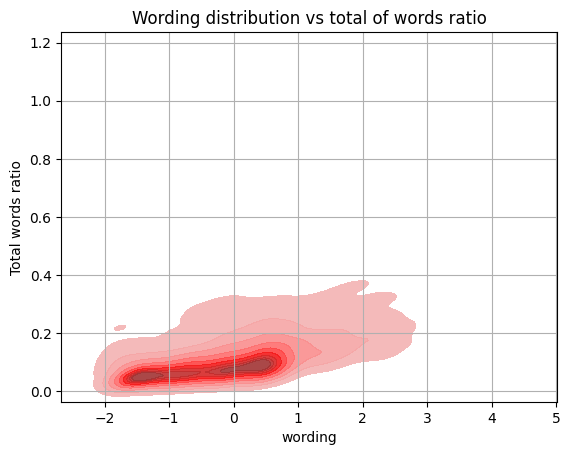

In [442]:
sns.kdeplot(data = summaries_train, x = "wording", y = "count_tp",color = "r", alpha = .9, fill = True)
plt.title("Wording distribution vs total of words ratio")
plt.ylabel("Total words ratio")
plt.grid()

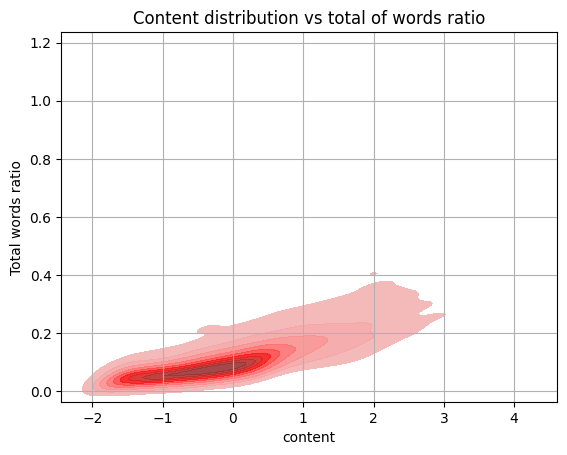

In [443]:
sns.kdeplot(data = summaries_train, x = "content", y = "count_tp",color = "r", alpha = .9, fill = True)
plt.title("Content distribution vs total of words ratio")
plt.ylabel("Total words ratio")
plt.grid()

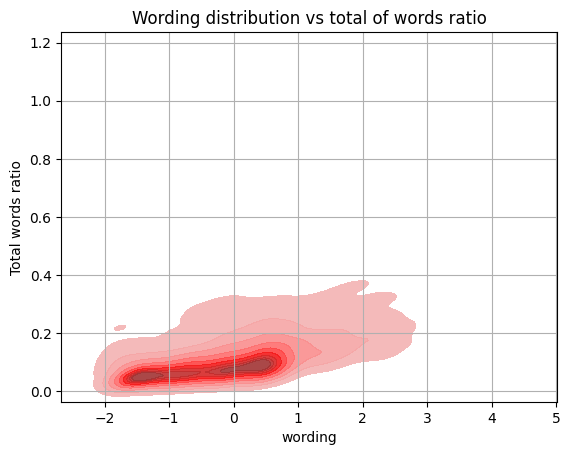

In [444]:
sns.kdeplot(data = summaries_train, x = "wording", y = "count_tp",color = "r", alpha = .9, fill = True)
plt.title("Wording distribution vs total of words ratio")
plt.ylabel("Total words ratio")
plt.grid()

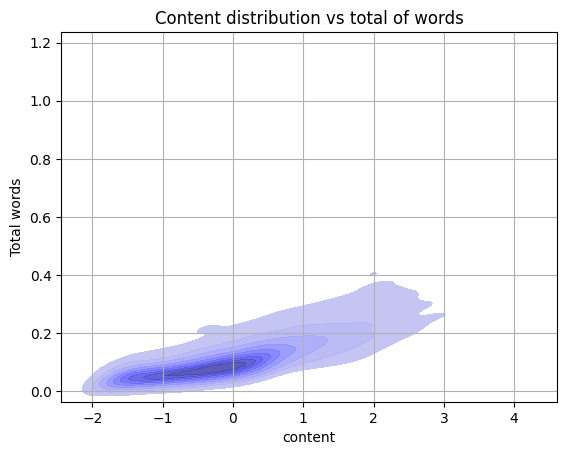

In [445]:
sns.kdeplot(data = summaries_train, x = "content", y = "count_tp",color = "b", alpha = .9, fill = True)
plt.title("Content distribution vs total of words")
plt.ylabel("Total words")
plt.grid()

In [446]:
stopwords = nltk.corpus.stopwords
stopwords = stopwords.words('english')

In [447]:
def count_stopwords(text, stopwords):
    split = text.lower().split(' ')
    count = 0
    for i in split:
        if i in stopwords:
            count += 1
    return count


In [448]:
summaries_train["stopwords"] = summaries_train['text'].apply(count_stopwords, stopwords = stopwords)
summaries_train

student_id prompt_id  \
0     000e8c3c7ddb    814d6b   
1     0070c9e7af47    814d6b   
2     0095993991fe    814d6b   
3     00c20c6ddd23    814d6b   
4     00d40ad10dc9    814d6b   
...            ...       ...   
7160  fef3e85236e5    39c16e   
7161  ff0f65eecf02    39c16e   
7162  ff186473ea0a    39c16e   
7163  ff5e9e6068da    39c16e   
7164  ffe4a98093b2    39c16e   

                                                   text   content   wording  \
0     The third wave was an experimentto see how peo...  0.205683  0.380538   
1     The Third Wave developed  rapidly because the ...  3.272894  3.219757   
2     The third wave only started as an experiment w...  0.205683  0.380538   
3     The experimen was orginally about how even whe...  0.567975  0.969062   
4     The third wave developed so quickly due to the... -0.910596 -0.081769   
...                                                 ...       ...       ...   
7160  It has to be made on a complex storyline, with... -0.981265 -1.548900   
7161  Aristotle descirbes an ideal tradgedy as being... -0.511077 -1.589115   
7162  A tragedy should have a complex plan not a sim... -0.834946 -0.593749   
7163  Aristotle believed that the ideal tradegy shou... -0.157460 -0.165811   
7164  An ideal tragety has three elements that make ... -0.393310  0.627128   

                                        prompt_question    prompt_title  \
0     Summarize how the Third Wave developed over su...  The Third Wave   
1     Summarize how the Third Wave developed over su...  The Third Wave   
2     Summarize how the Third Wave developed over su...  The Third Wave   
3     Summarize how the Third Wave developed over su...  The Third Wave   
4     Summarize how the Third Wave developed over su...  The Third Wave   
...                                                 ...             ...   
7160  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7161  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7162  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7163  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7164  Summarize at least 3 elements of an ideal trag...      On Tragedy   

                                            prompt_text  count_tp  stopwords  
0     Background \r\nThe Third Wave experiment took ...  0.102349         25  
1     Background \r\nThe Third Wave experiment took ...  0.340604         92  
2     Background \r\nThe Third Wave experiment took ...  0.100671         27  
3     Background \r\nThe Third Wave experiment took ...  0.127517         35  
4     Background \r\nThe Third Wave experiment took ...  0.045302         12  
...                                                 ...       ...        ...  
7160  Chapter 13 \r\nAs the sequel to what has alrea...  0.054636         16  
7161  Chapter 13 \r\nAs the sequel to what has alrea...  0.049669         15  
7162  Chapter 13 \r\nAs the sequel to what has alrea...  0.048013         16  
7163  Chapter 13 \r\nAs the sequel to what has alrea...  0.081126         22  
7164  Chapter 13 \r\nAs the sequel to what has alrea...  0.097682         27  

[7165 rows x 10 columns]

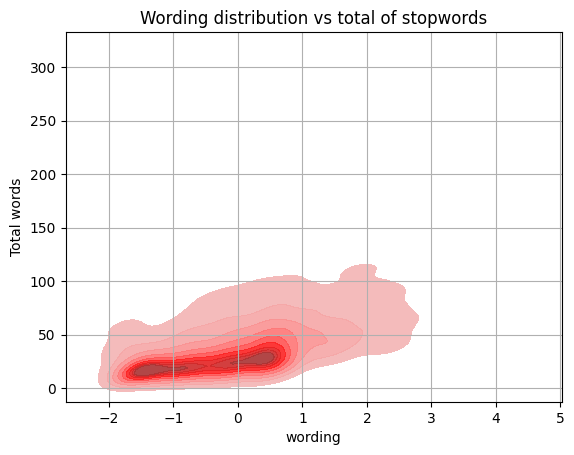

In [449]:
sns.kdeplot(data = summaries_train, x = "wording", y = "stopwords",color = "r", alpha = .9, fill = True)
plt.title("Wording distribution vs total of stopwords")
plt.ylabel("Total words")
plt.grid()

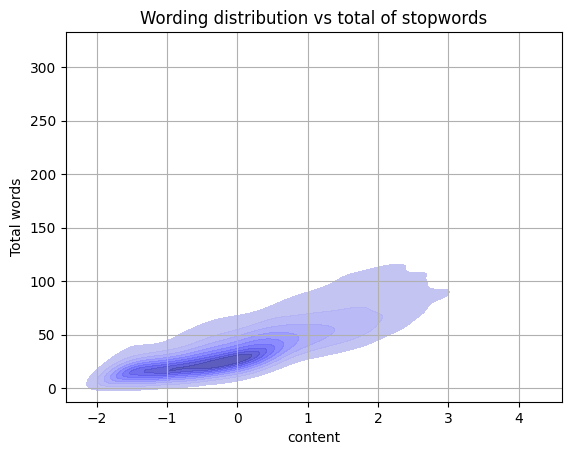

In [450]:
sns.kdeplot(data = summaries_train, x = "content", y = "stopwords",color = "b", alpha = .9, fill = True)
plt.title("Wording distribution vs total of stopwords")
plt.ylabel("Total words")
plt.grid()

In [451]:
summaries_train["punctuation"] = summaries_train['text'].str.count(r'[\.,\n]')
summaries_train

student_id prompt_id  \
0     000e8c3c7ddb    814d6b   
1     0070c9e7af47    814d6b   
2     0095993991fe    814d6b   
3     00c20c6ddd23    814d6b   
4     00d40ad10dc9    814d6b   
...            ...       ...   
7160  fef3e85236e5    39c16e   
7161  ff0f65eecf02    39c16e   
7162  ff186473ea0a    39c16e   
7163  ff5e9e6068da    39c16e   
7164  ffe4a98093b2    39c16e   

                                                   text   content   wording  \
0     The third wave was an experimentto see how peo...  0.205683  0.380538   
1     The Third Wave developed  rapidly because the ...  3.272894  3.219757   
2     The third wave only started as an experiment w...  0.205683  0.380538   
3     The experimen was orginally about how even whe...  0.567975  0.969062   
4     The third wave developed so quickly due to the... -0.910596 -0.081769   
...                                                 ...       ...       ...   
7160  It has to be made on a complex storyline, with... -0.981265 -1.548900   
7161  Aristotle descirbes an ideal tradgedy as being... -0.511077 -1.589115   
7162  A tragedy should have a complex plan not a sim... -0.834946 -0.593749   
7163  Aristotle believed that the ideal tradegy shou... -0.157460 -0.165811   
7164  An ideal tragety has three elements that make ... -0.393310  0.627128   

                                        prompt_question    prompt_title  \
0     Summarize how the Third Wave developed over su...  The Third Wave   
1     Summarize how the Third Wave developed over su...  The Third Wave   
2     Summarize how the Third Wave developed over su...  The Third Wave   
3     Summarize how the Third Wave developed over su...  The Third Wave   
4     Summarize how the Third Wave developed over su...  The Third Wave   
...                                                 ...             ...   
7160  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7161  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7162  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7163  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7164  Summarize at least 3 elements of an ideal trag...      On Tragedy   

                                            prompt_text  count_tp  stopwords  \
0     Background \r\nThe Third Wave experiment took ...  0.102349         25   
1     Background \r\nThe Third Wave experiment took ...  0.340604         92   
2     Background \r\nThe Third Wave experiment took ...  0.100671         27   
3     Background \r\nThe Third Wave experiment took ...  0.127517         35   
4     Background \r\nThe Third Wave experiment took ...  0.045302         12   
...                                                 ...       ...        ...   
7160  Chapter 13 \r\nAs the sequel to what has alrea...  0.054636         16   
7161  Chapter 13 \r\nAs the sequel to what has alrea...  0.049669         15   
7162  Chapter 13 \r\nAs the sequel to what has alrea...  0.048013         16   
7163  Chapter 13 \r\nAs the sequel to what has alrea...  0.081126         22   
7164  Chapter 13 \r\nAs the sequel to what has alrea...  0.097682         27   

      punctuation  
0               3  
1              18  
2               5  
3               8  
4               2  
...           ...  
7160            1  
7161            3  
7162            3  
7163            4  
7164            4  

[7165 rows x 11 columns]

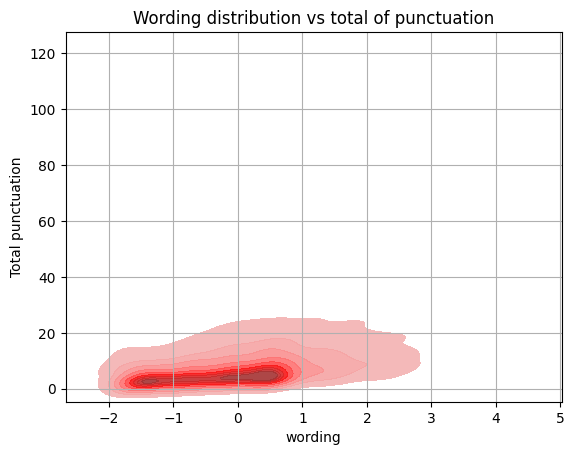

In [452]:
sns.kdeplot(data = summaries_train, x = "wording", y = "punctuation",color = "r", alpha = .9, fill = True)
plt.title("Wording distribution vs total of punctuation")
plt.ylabel("Total punctuation")
plt.grid()

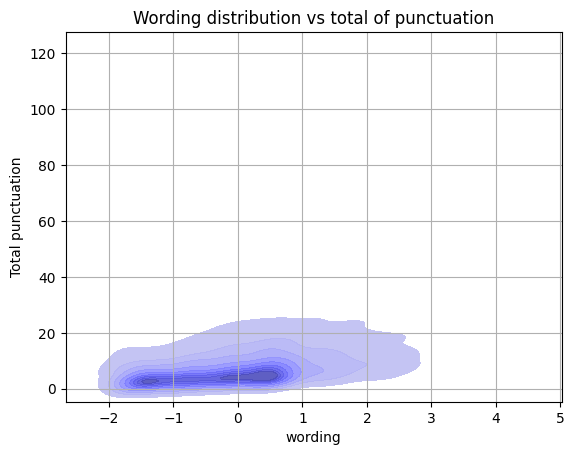

In [453]:
sns.kdeplot(data = summaries_train, x = "wording", y = "punctuation",color = "b", alpha = .9, fill = True)
plt.title("Wording distribution vs total of punctuation")
plt.ylabel("Total punctuation")
plt.grid()

In [454]:
summaries_train['lower_t'] = summaries_train['text'].str.lower().str.replace('[^a-z0-9 ]+', ' ', regex = True)
summaries_train['lower_p'] = summaries_train['prompt_text'].str.lower().str.replace('[^a-z0-9 ]+', ' ', regex = True)
summaries_train['lower'] = summaries_train['lower_p'] + ' ' + summaries_train['lower_t']
summaries_train

student_id prompt_id  \
0     000e8c3c7ddb    814d6b   
1     0070c9e7af47    814d6b   
2     0095993991fe    814d6b   
3     00c20c6ddd23    814d6b   
4     00d40ad10dc9    814d6b   
...            ...       ...   
7160  fef3e85236e5    39c16e   
7161  ff0f65eecf02    39c16e   
7162  ff186473ea0a    39c16e   
7163  ff5e9e6068da    39c16e   
7164  ffe4a98093b2    39c16e   

                                                   text   content   wording  \
0     The third wave was an experimentto see how peo...  0.205683  0.380538   
1     The Third Wave developed  rapidly because the ...  3.272894  3.219757   
2     The third wave only started as an experiment w...  0.205683  0.380538   
3     The experimen was orginally about how even whe...  0.567975  0.969062   
4     The third wave developed so quickly due to the... -0.910596 -0.081769   
...                                                 ...       ...       ...   
7160  It has to be made on a complex storyline, with... -0.981265 -1.548900   
7161  Aristotle descirbes an ideal tradgedy as being... -0.511077 -1.589115   
7162  A tragedy should have a complex plan not a sim... -0.834946 -0.593749   
7163  Aristotle believed that the ideal tradegy shou... -0.157460 -0.165811   
7164  An ideal tragety has three elements that make ... -0.393310  0.627128   

                                        prompt_question    prompt_title  \
0     Summarize how the Third Wave developed over su...  The Third Wave   
1     Summarize how the Third Wave developed over su...  The Third Wave   
2     Summarize how the Third Wave developed over su...  The Third Wave   
3     Summarize how the Third Wave developed over su...  The Third Wave   
4     Summarize how the Third Wave developed over su...  The Third Wave   
...                                                 ...             ...   
7160  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7161  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7162  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7163  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7164  Summarize at least 3 elements of an ideal trag...      On Tragedy   

                                            prompt_text  count_tp  stopwords  \
0     Background \r\nThe Third Wave experiment took ...  0.102349         25   
1     Background \r\nThe Third Wave experiment took ...  0.340604         92   
2     Background \r\nThe Third Wave experiment took ...  0.100671         27   
3     Background \r\nThe Third Wave experiment took ...  0.127517         35   
4     Background \r\nThe Third Wave experiment took ...  0.045302         12   
...                                                 ...       ...        ...   
7160  Chapter 13 \r\nAs the sequel to what has alrea...  0.054636         16   
7161  Chapter 13 \r\nAs the sequel to what has alrea...  0.049669         15   
7162  Chapter 13 \r\nAs the sequel to what has alrea...  0.048013         16   
7163  Chapter 13 \r\nAs the sequel to what has alrea...  0.081126         22   
7164  Chapter 13 \r\nAs the sequel to what has alrea...  0.097682         27   

      punctuation                                            lower_t  \
0               3  the third wave was an experimentto see how peo...   
1              18  the third wave developed  rapidly because the ...   
2               5  the third wave only started as an experiment w...   
3               8  the experimen was orginally about how even whe...   
4               2  the third wave developed so quickly due to the...   
...           ...                                                ...   
7160            1  it has to be made on a complex storyline  with...   
7161            3  aristotle descirbes an ideal tradgedy as being...   
7162            3  a tragedy should have a complex plan not a sim...   
7163            4  aristotle believed that the ideal tradegy shou...   
7164            4  a

In [455]:
def preprocess_hard(text, join_back=True):
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    filtered_tokens = []
    
    for token in tokens:
        # Stop Words Cleaning
        if token not in stopwords and token.isalpha():
            filtered_tokens.append(token)
    
    if join_back:
        result = " ".join(filtered_tokens)
    else:
        result = filtered_tokens
    
    return result

In [456]:
nltk.download('punkt')

def collapse_dots(input):
    input = re.sub("\.+", ".", input)
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output


def process_light(input):
    if isinstance(input, str):
        input = " ".join(tokenize.sent_tokenize(input))
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub("[^а-яА-Яa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ё]+", " ", input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
        # input = input.lower()
    return input

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [457]:
summaries_train["hard_clean_text"] = summaries_train['lower'].apply(preprocess_hard)
summaries_train["light_clean_text"] = summaries_train['lower'].apply(process_light)

In [458]:
idx = 10

print(
    f"Before : {summaries_train['lower'].iloc[idx]}\n"
    f"Hard Processing : {summaries_train['hard_clean_text'].iloc[idx]}\n"
    f"Light Processing : {summaries_train['light_clean_text'].iloc[idx]}\n"
)

idx = 100

print(
    f"Before : {summaries_train['lower'].iloc[idx]}\n"
    f"Hard Processing : {summaries_train['hard_clean_text'].iloc[idx]}\n"
    f"Light Processing : {summaries_train['light_clean_text'].iloc[idx]}\n"
)

Before : background  the third wave experiment took place at cubberley high school in palo alto  california during the first week of april 1967  history teacher ron jones  finding himself unable to explain to his students how people throughout history followed the crowd even when terrible things were happening  decided to demonstrate it to his students through an experiment  jones announced that he was starting a movement aimed to eliminate democracy  jones named the movement  the third wave  as a symbol of strength  referring to the mythical belief that the third in a series of waves is the strongest  one of the central points of this movement was that democracy s main weakness is that it favors the individual over the whole community  jones emphasized this main point of the movement when he created this catchy motto   strength through discipline  strength through community  strength through action  strength through pride   the experiment  jones started the first day of the experiment

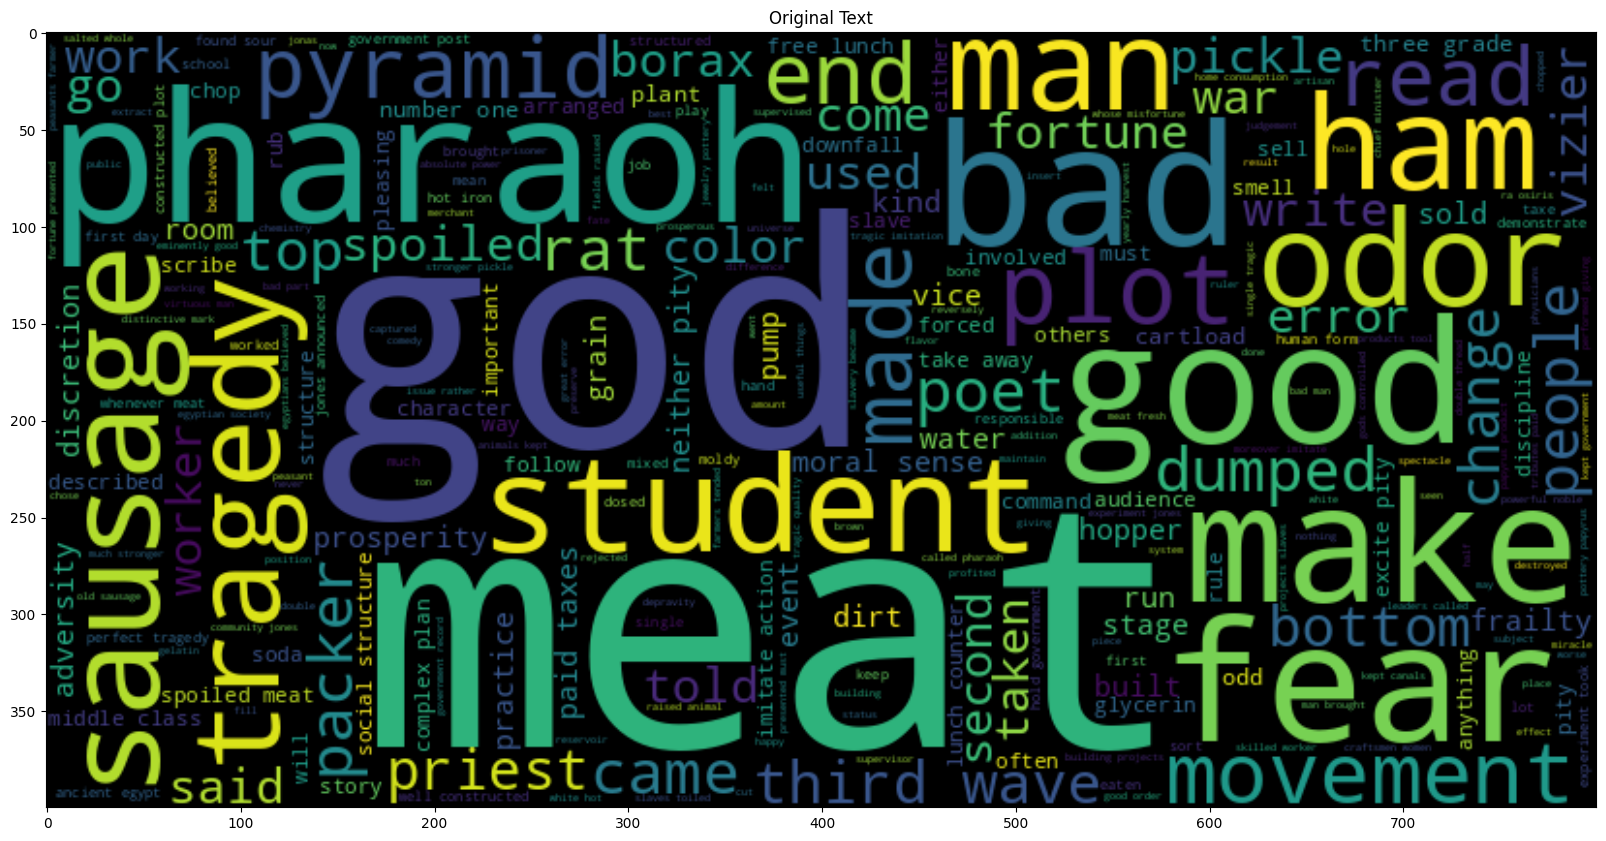

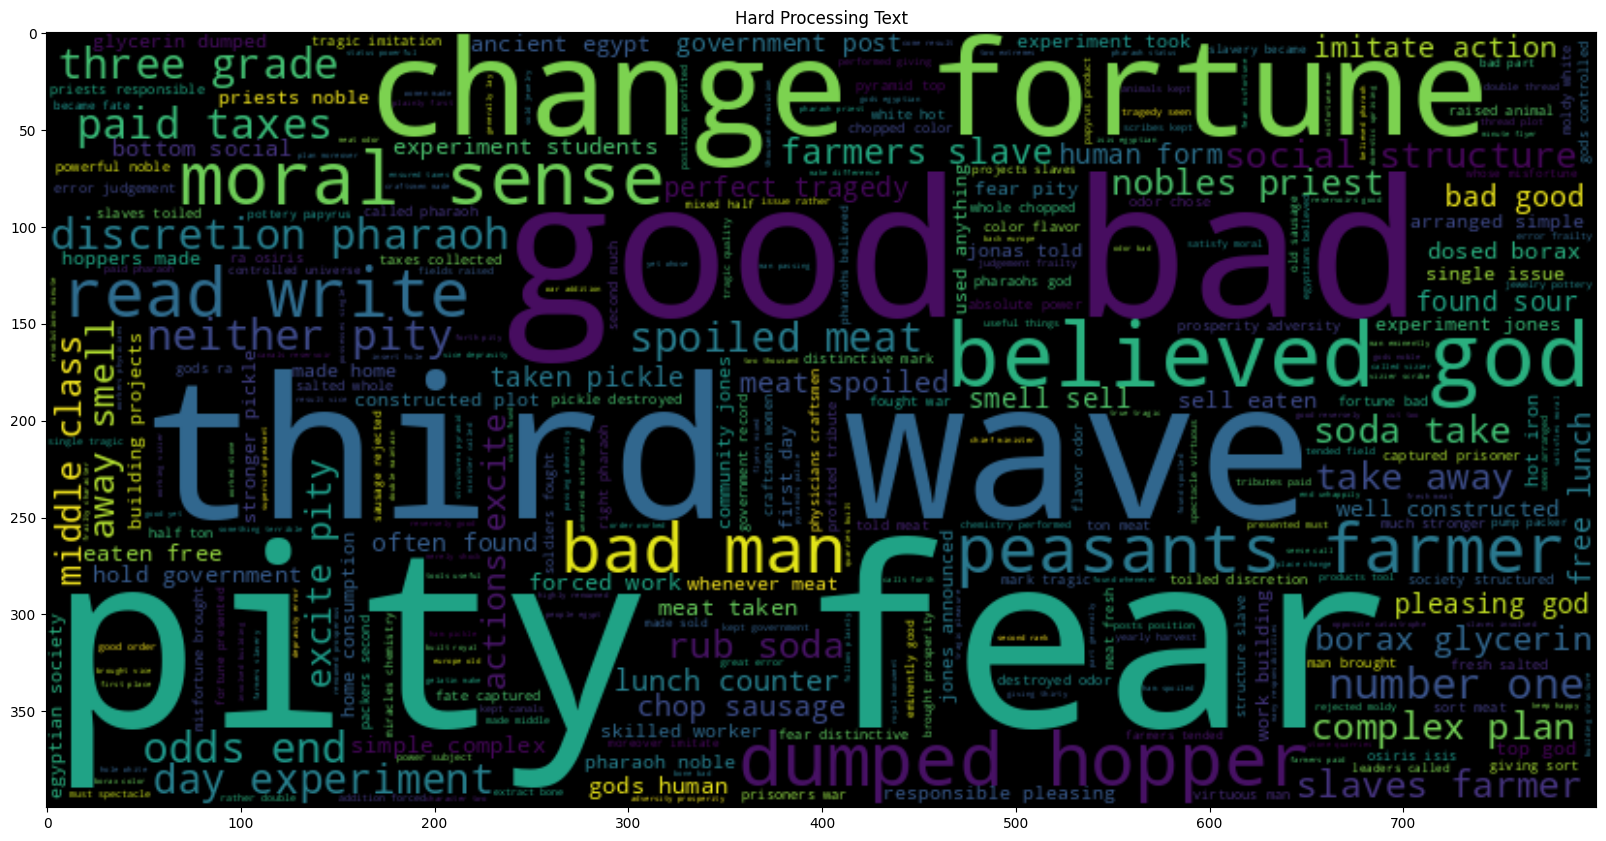

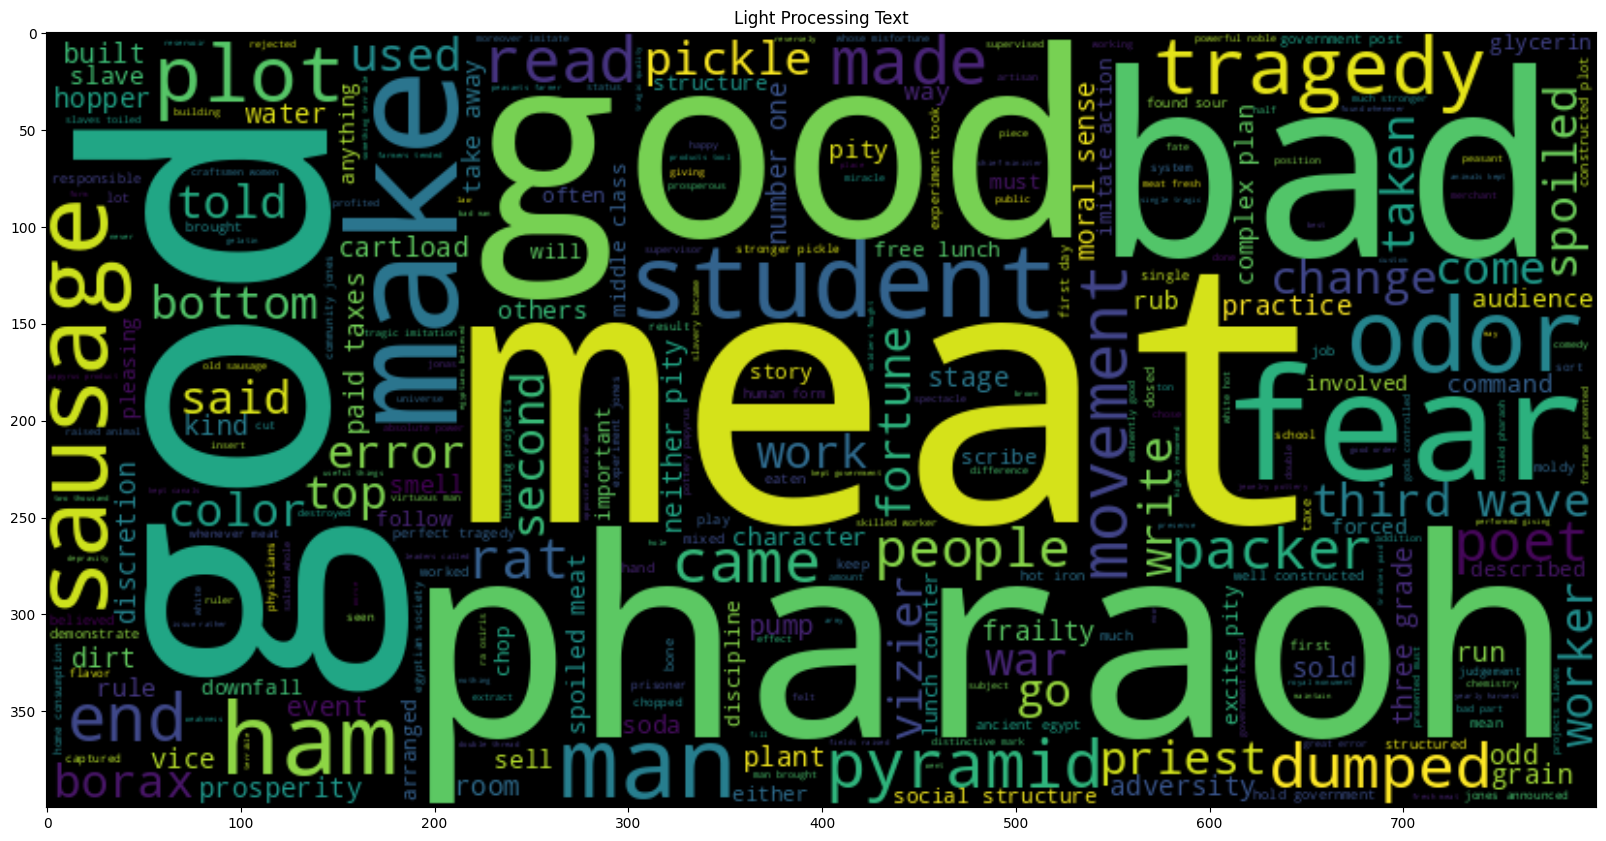

In [459]:
plt.figure(figsize = (20, 20)) 
plt.title("Original Text")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(summaries_train['lower']))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20, 20)) 
plt.title("Hard Processing Text")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(summaries_train['hard_clean_text']))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20, 20)) 
plt.title("Light Processing Text")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(summaries_train['light_clean_text']))
plt.imshow(wc, interpolation = 'bilinear')

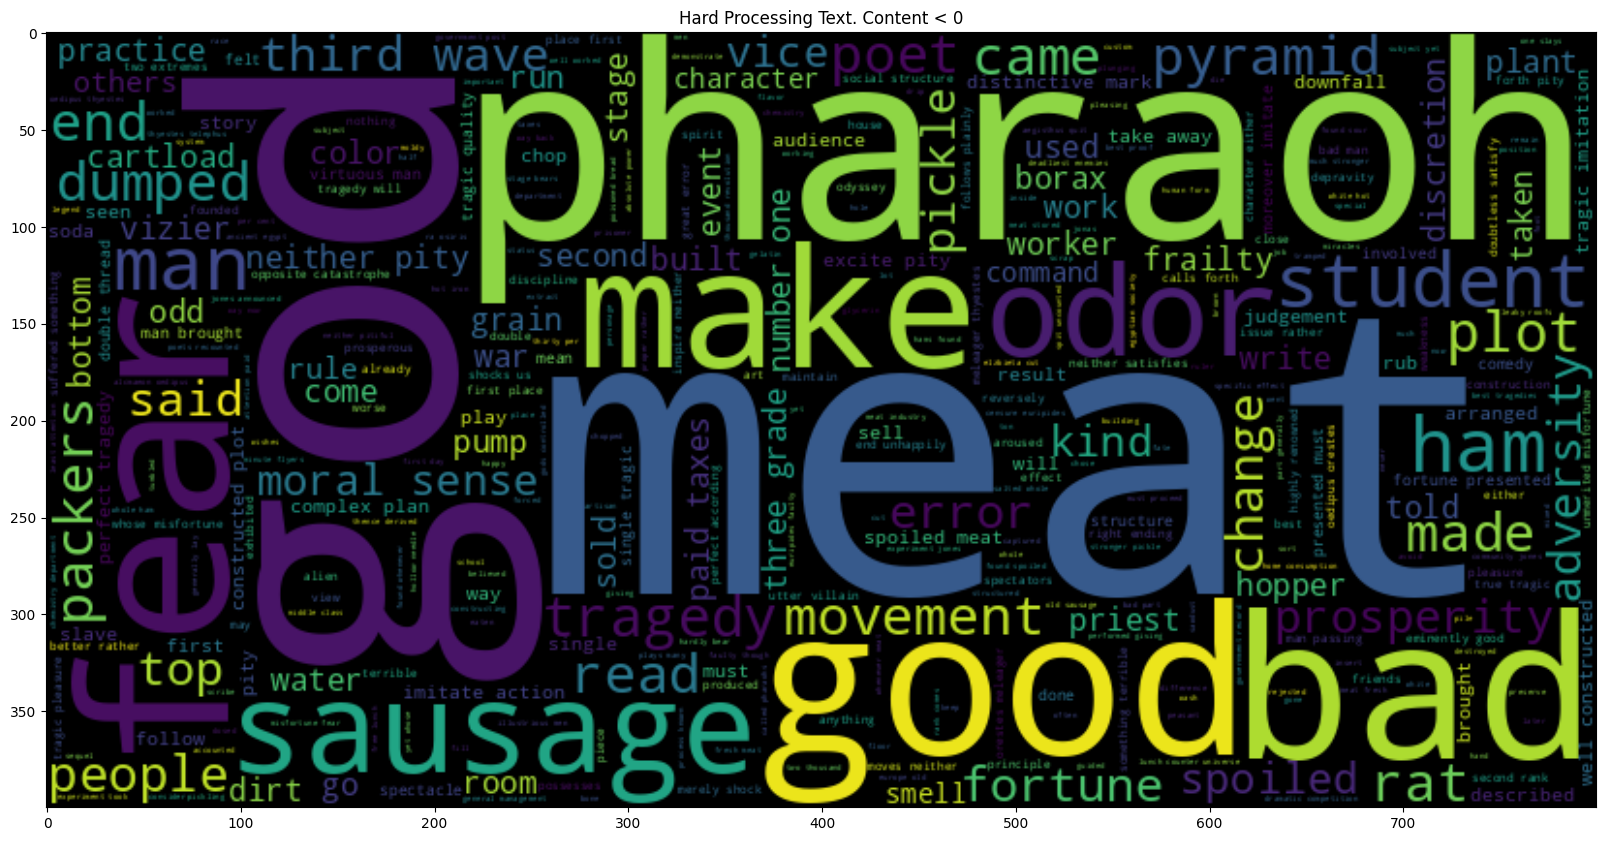

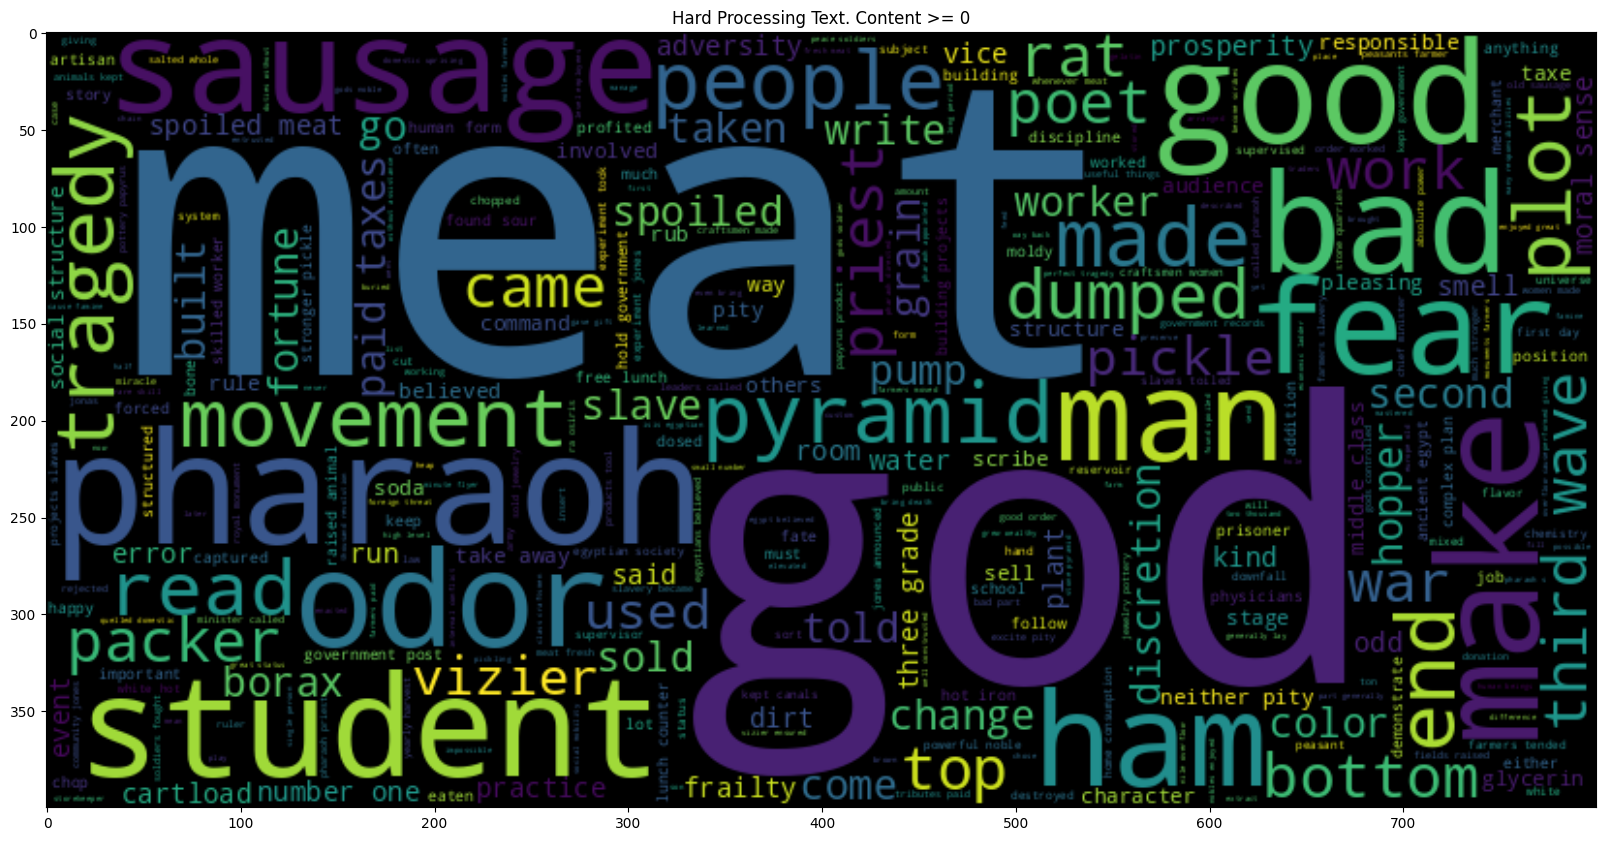

In [460]:
plt.figure(figsize = (20,20)) 
plt.title("Hard Processing Text. Content < 0")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(summaries_train.loc[summaries_train["content"] < 0, 'light_clean_text']))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20,20)) 
plt.title("Hard Processing Text. Content >= 0")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(summaries_train.loc[summaries_train["content"] >= 0, 'light_clean_text']))
plt.imshow(wc, interpolation = 'bilinear')

In [461]:
summaries_train

student_id prompt_id  \
0     000e8c3c7ddb    814d6b   
1     0070c9e7af47    814d6b   
2     0095993991fe    814d6b   
3     00c20c6ddd23    814d6b   
4     00d40ad10dc9    814d6b   
...            ...       ...   
7160  fef3e85236e5    39c16e   
7161  ff0f65eecf02    39c16e   
7162  ff186473ea0a    39c16e   
7163  ff5e9e6068da    39c16e   
7164  ffe4a98093b2    39c16e   

                                                   text   content   wording  \
0     The third wave was an experimentto see how peo...  0.205683  0.380538   
1     The Third Wave developed  rapidly because the ...  3.272894  3.219757   
2     The third wave only started as an experiment w...  0.205683  0.380538   
3     The experimen was orginally about how even whe...  0.567975  0.969062   
4     The third wave developed so quickly due to the... -0.910596 -0.081769   
...                                                 ...       ...       ...   
7160  It has to be made on a complex storyline, with... -0.981265 -1.548900   
7161  Aristotle descirbes an ideal tradgedy as being... -0.511077 -1.589115   
7162  A tragedy should have a complex plan not a sim... -0.834946 -0.593749   
7163  Aristotle believed that the ideal tradegy shou... -0.157460 -0.165811   
7164  An ideal tragety has three elements that make ... -0.393310  0.627128   

                                        prompt_question    prompt_title  \
0     Summarize how the Third Wave developed over su...  The Third Wave   
1     Summarize how the Third Wave developed over su...  The Third Wave   
2     Summarize how the Third Wave developed over su...  The Third Wave   
3     Summarize how the Third Wave developed over su...  The Third Wave   
4     Summarize how the Third Wave developed over su...  The Third Wave   
...                                                 ...             ...   
7160  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7161  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7162  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7163  Summarize at least 3 elements of an ideal trag...      On Tragedy   
7164  Summarize at least 3 elements of an ideal trag...      On Tragedy   

                                            prompt_text  count_tp  stopwords  \
0     Background \r\nThe Third Wave experiment took ...  0.102349         25   
1     Background \r\nThe Third Wave experiment took ...  0.340604         92   
2     Background \r\nThe Third Wave experiment took ...  0.100671         27   
3     Background \r\nThe Third Wave experiment took ...  0.127517         35   
4     Background \r\nThe Third Wave experiment took ...  0.045302         12   
...                                                 ...       ...        ...   
7160  Chapter 13 \r\nAs the sequel to what has alrea...  0.054636         16   
7161  Chapter 13 \r\nAs the sequel to what has alrea...  0.049669         15   
7162  Chapter 13 \r\nAs the sequel to what has alrea...  0.048013         16   
7163  Chapter 13 \r\nAs the sequel to what has alrea...  0.081126         22   
7164  Chapter 13 \r\nAs the sequel to what has alrea...  0.097682         27   

      punctuation                                            lower_t  \
0               3  the third wave was an experimentto see how peo...   
1              18  the third wave developed  rapidly because the ...   
2               5  the third wave only started as an experiment w...   
3               8  the experimen was orginally about how even whe...   
4               2  the third wave developed so quickly due to the...   
...           ...                                                ...   
7160            1  it has to be made on a complex storyline  with...   
7161            3  aristotle descirbes an ideal tradgedy as being...   
7162            3  a tragedy should have a complex plan not a sim...   
7163            4  aristotle believed that the ideal tradegy shou...   
7164            4  a

In [462]:
summaries_train = summaries_train.drop(['student_id', 'prompt_id', 'text', 'prompt_title', 'prompt_text', 'lower_t', 'lower_p', 'lower', 'light_clean_text'], axis = 1)
summaries_train

content   wording                                    prompt_question  \
0     0.205683  0.380538  Summarize how the Third Wave developed over su...   
1     3.272894  3.219757  Summarize how the Third Wave developed over su...   
2     0.205683  0.380538  Summarize how the Third Wave developed over su...   
3     0.567975  0.969062  Summarize how the Third Wave developed over su...   
4    -0.910596 -0.081769  Summarize how the Third Wave developed over su...   
...        ...       ...                                                ...   
7160 -0.981265 -1.548900  Summarize at least 3 elements of an ideal trag...   
7161 -0.511077 -1.589115  Summarize at least 3 elements of an ideal trag...   
7162 -0.834946 -0.593749  Summarize at least 3 elements of an ideal trag...   
7163 -0.157460 -0.165811  Summarize at least 3 elements of an ideal trag...   
7164 -0.393310  0.627128  Summarize at least 3 elements of an ideal trag...   

      count_tp  stopwords  punctuation  \
0     0.102349         25            3   
1     0.340604         92           18   
2     0.100671         27            5   
3     0.127517         35            8   
4     0.045302         12            2   
...        ...        ...          ...   
7160  0.054636         16            1   
7161  0.049669         15            3   
7162  0.048013         16            3   
7163  0.081126         22            4   
7164  0.097682         27            4   

                                        hard_clean_text  
0     background third wave experiment took place cu...  
1     background third wave experiment took place cu...  
2     background third wave experiment took place cu...  
3     background third wave experiment took place cu...  
4     background third wave experiment took place cu...  
...                                                 ...  
7160  chapter sequel already said must proceed consi...  
7161  chapter sequel already said must proceed consi...  
7162  chapter sequel already said must proceed consi...  
7163  chapter sequel already said must proceed consi...  
7164  chapter sequel already said must proceed consi...  

[7165 rows x 7 columns]

In [463]:
summaries_train = summaries_train.drop('prompt_question', axis = 1)


In [464]:
summaries_train

content   wording  count_tp  stopwords  punctuation  \
0     0.205683  0.380538  0.102349         25            3   
1     3.272894  3.219757  0.340604         92           18   
2     0.205683  0.380538  0.100671         27            5   
3     0.567975  0.969062  0.127517         35            8   
4    -0.910596 -0.081769  0.045302         12            2   
...        ...       ...       ...        ...          ...   
7160 -0.981265 -1.548900  0.054636         16            1   
7161 -0.511077 -1.589115  0.049669         15            3   
7162 -0.834946 -0.593749  0.048013         16            3   
7163 -0.157460 -0.165811  0.081126         22            4   
7164 -0.393310  0.627128  0.097682         27            4   

                                        hard_clean_text  
0     background third wave experiment took place cu...  
1     background third wave experiment took place cu...  
2     background third wave experiment took place cu...  
3     background third wave experiment took place cu...  
4     background third wave experiment took place cu...  
...                                                 ...  
7160  chapter sequel already said must proceed consi...  
7161  chapter sequel already said must proceed consi...  
7162  chapter sequel already said must proceed consi...  
7163  chapter sequel already said must proceed consi...  
7164  chapter sequel already said must proceed consi...  

[7165 rows x 6 columns]

In [465]:
bow_counts = CountVectorizer(tokenizer = word_tokenize, stop_words = stopwords, ngram_range = (1, 2))

In [466]:
reviews_train, reviews_test = train_test_split(summaries_train, test_size = 0.2, random_state = 42)

In [467]:
scaler1 = RobustScaler()
scaler2 = RobustScaler()

y_train_c = scaler1.fit_transform(reviews_train[['content']])
y_test_c = scaler1.transform(reviews_test[['content']])

y_train_w = scaler2.fit_transform(reviews_train[['wording']])
y_test_w = scaler2.transform(reviews_test[['wording']])

In [468]:
y_train_c.shape

(5732, 1)

In [469]:
y_train_w.shape

(5732, 1)

In [470]:
X_train = bow_counts.fit_transform(reviews_train['hard_clean_text'])

X_test = bow_counts.transform(reviews_test['hard_clean_text'])

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [471]:
X_train.shape

(5732, 90272)

In [472]:
y_train_c.shape

(5732, 1)

In [473]:
y_train_w.shape

(5732, 1)

In [474]:
model_for_content = LinearRegression()
model_for_content.fit(X_train, y_train_c)

LinearRegression()

In [475]:
test_pred = model_for_content.predict(X_test)
print("RSME: ", np.sqrt(mean_squared_error(y_test_c, test_pred)))

RSME:  0.530858261049334


In [476]:
model_for_wording = LinearRegression()
model_for_wording.fit(X_train, y_train_w)

LinearRegression()

In [477]:
test_pred = model_for_wording.predict(X_test) 
print("RSME: ", np.sqrt(mean_squared_error(y_test_w, test_pred)))

RSME:  0.555953216251554


In [478]:
summaries_test['lower'] = summaries_test['text'].str.lower().str.replace('[^a-z0-9 ]+', ' ', regex=True)
summaries_test

student_id prompt_id            text           lower
0  000000ffffff    abc123  Example text 1  example text 1
1  111111eeeeee    def789  Example text 2  example text 2
2  222222cccccc    abc123  Example text 3  example text 3
3  333333dddddd    def789  Example text 4  example text 4

In [479]:
X_test_final = bow_counts.transform(summaries_test.lower)

In [480]:
sample_submission["content"] = scaler1.inverse_transform(model_for_content.predict(X_test_final))
sample_submission["wording"] = scaler2.inverse_transform(model_for_wording.predict(X_test_final))
sample_submission

student_id   content  wording
0  000000ffffff -6.081274 -0.50681
1  111111eeeeee -6.081274 -0.50681
2  222222cccccc -6.081274 -0.50681
3  333333dddddd -6.081274 -0.50681

In [481]:
sample_submission.to_csv("submission.csv",index = False) 